# Comparing torch & TF2 implementations: Ackley

Comparing NN-INF performances on synthetic function optimization.

See `exp_sim_optim_simple.py` for base code.

In [1]:
from exp_sim_optim_simple import (
    setup_objective,
    run_sim_optim_gp,
    run_sim_optim_torch,
    run_sim_optim_tf2,
    eval_hook,
    report_result,
    plot_regrets,
    plot_surface,
)

import numpy as np
import torch
import tensorflow as tf

In [2]:
print("torch:", torch.__version__)
print("tensorflow:", tf.__version__)

torch: 1.7.1
tensorflow: 2.4.1


## Problem: Finding Minimum of the 2D Ackley Function

In [3]:
np.random.seed(1)
torch.manual_seed(2)
tf.random.set_seed(3)

In [4]:
# Common arguments
input_dim = 2
init_points = 10
max_iter = 100

In [5]:
X, Y, domain, problem = setup_objective(
    "Ackley", 
    input_dim,
    init_points,
)

## Baseline: GP-LCB

minimum: 0.03192898914878706
minimizer: [-0.00920739  0.00459905]
elapsed time: 31.34 seconds


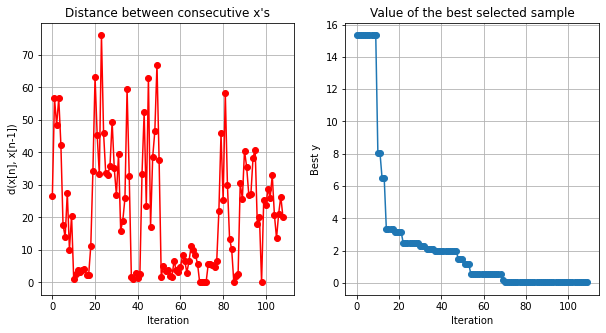

In [6]:
# ~45 seconds on laptop
gp_opt = run_sim_optim_gp(
    X,
    Y,
    domain,
    problem,
    max_iter=max_iter,
    acquisition_type="LCB",
)

## NN-INF (torch)

In [7]:
# Size of NN estimator
layer_sizes = [8, 8, 4]

Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

FCNet(
  (fc_0): Linear(in_features=2, out_features=8, bias=True)
  (fc_1): Linear(in_features=8, out_features=8, bias=True)
  (fc_2): Linear(in_features=8, out_features=4, bias=True)
  (fc_last): Linear(in_features=4, out_features=1, bias=True)
  (scale): Linear(in_features=1, out_features=1, bias=True)
)
Models printout after each iteration is only available for GP and GP_MCMC models


Optimizing: 100%|██████████| 100/100 [00:22<00:00,  4.54it/s, R_i=21.6, exp_w=4.81, f*hat=21.6, fhat_i=21.6, r_i=21.6, t_i=0.207, y_i=21.6, μ*=21.6, σ*=0.0188]


Elapsed Time: 22.02s
predicted minimum value: 11.738887786865234 +/- 0.04667766019701958
predicted minimizer: [-1.20656797 -4.61938533]
actual value at predicted minimizer: 11.743452143215643


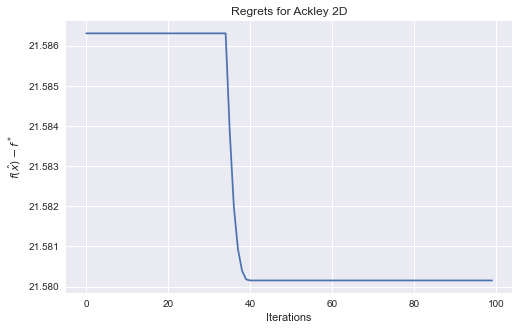

In [8]:
# ~45 seconds
nninf_torch = run_sim_optim_torch(
    X,
    Y,
    domain,
    problem,
    max_iter=max_iter,
    layer_sizes=layer_sizes,
)

## NN-INF (tf2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

Models printout after each iteration is only available for GP and GP_MCMC models


Optimizing: 100%|██████████| 100/100 [03:46<00:00,  2.26s/it, R_i=12.9, exp_w=4.81, f*hat=12.9, fhat_i=12.9, r_i=12.9, t_i=1.33, y_i=12.9, μ*=13.1, σ*=0.818]

Elapsed Time: 226.43s
predicted minimum value: 11.85112476348877 +/- 0.3282392621040344
predicted minimizer: [ 0.54437572 -4.55059683]
actual value at predicted minimizer: 11.873361131362525


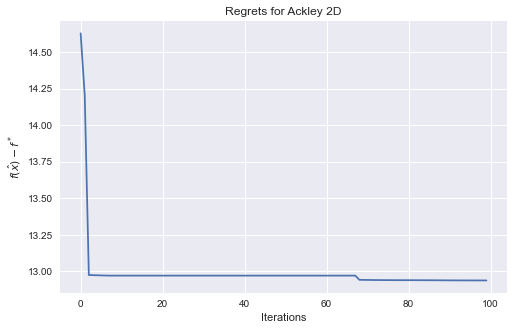

In [9]:
# ~250 seconds
nninf_tf2 = run_sim_optim_tf2(
    X,
    Y,
    domain,
    problem,
    max_iter=max_iter,
    layer_sizes=layer_sizes,
)

## Combined Results

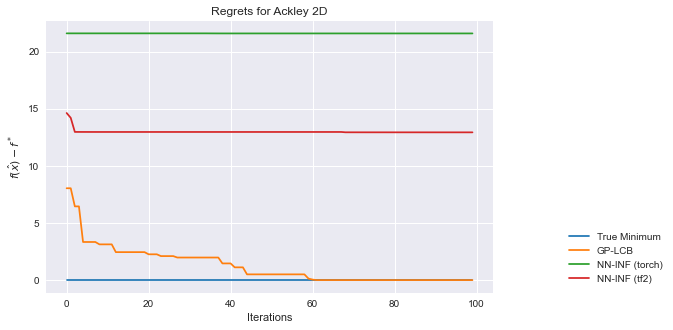

In [10]:
plot_regrets(
    [np.repeat(0, max_iter), 
     gp_opt.Y_best[-max_iter:] - problem.fmin, 
     nninf_torch["regrets"], 
     nninf_tf2["regrets"]],
    problem.name, 
    ["True Minimum", "GP-LCB", "NN-INF (torch)", "NN-INF (tf2)"],
)

True Minimum    : min 0.00000 at [0.0, 0.0]
GP-LCB          : min 0.03193 at [-0.00920739  0.00459905]
NN-INF (torch)  : min 11.74345 at [-1.20656797 -4.61938533]
NN-INF (tf2)    : min 11.87336 at [ 0.54437572 -4.55059683]


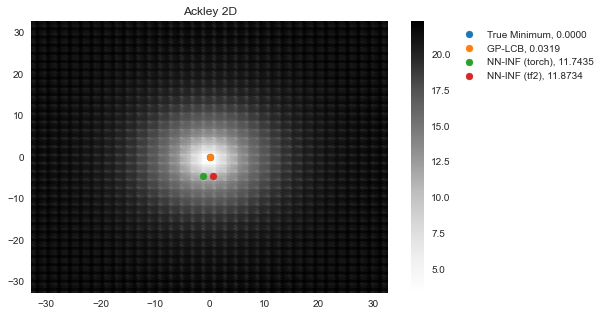

In [11]:
# NN Surface
minimizers = [
    (problem.min, problem.fmin, "True Minimum"),
    (gp_opt.x_opt, gp_opt.fx_opt, "GP-LCB"),
    (nninf_torch["bo"].x_opt, nninf_torch["bo"].fx_opt, "NN-INF (torch)"),
    (nninf_tf2["bo"].x_opt, nninf_tf2["bo"].fx_opt, "NN-INF (tf2)"),
]

plot_surface(problem, problem.bounds[0][1], minimizers, problem.name)